In [1]:
# Dependency management
# --------------------------------------------------------
import sys
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root / "scripts"))
from setup_environment import setup_paths
project_root = setup_paths()

# Data manipulation
# --------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl
import math
import time

# Visualizations
# --------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import altair as alt
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from bokeh.plotting import figure, show
import seaborn.objects as so
import plotly.express as px

# Custom scripts
# ---------------------------------------------------------
from data_processing.cleaner import (cleaning, 
                                     compare_and_drop_duplicates)
from feature_selection.selector import (select_vars, 
                                       choose_variable_to_drop, 
                                       corr_comparison, 
                                       mutual_information)

# Correlation
# ---------------------------------------------------------
from dython.nominal import associations

# Dimension Reduction
# ---------------------------------------------------------
import umap

# Preprocessing
# ---------------------------------------------------------
from sklearn.preprocessing import (MinMaxScaler, 
                                   RobustScaler, 
                                   QuantileTransformer, 
                                   OrdinalEncoder)
from sklearn import preprocessing
from category_encoders import BinaryEncoder

# Random Forest
# ---------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier

# XGBoost
# ---------------------------------------------------------
import xgboost as xgb
from xgboost import XGBClassifier

# Model selection
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

# Metrics
# ---------------------------------------------------------
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix,
                            classification_report
                            )

# Other
# ---------------------------------------------------------
from collections import Counter
from tqdm import tqdm
import random
random.seed(2024)
import warnings
warnings.simplefilter("ignore", FutureWarning)

In [2]:
# Load saved merged_df.csv
merged_df = pd.read_csv(f"{project_root}/data/interim/merged_df.csv")
print(merged_df.shape)
print()
print(merged_df.columns)

(328116, 31)

Index(['#chrom', 'chromStart', 'chromEnd', 'name', 'score', 'reserved',
       'blockSizes', 'clinSign', 'reviewStatus', 'type', 'molConseq',
       'testedInGtr', 'phenotypeList', 'origin', 'cytogenetic', 'vcfDesc',
       '_clinSignCode', 'simplified_hgvs', 'Gene', 'ClinClass',
       'Classification', 'bin_class', 'classification_oncokb', 'gen',
       'gen_label', 'string_per_umap_cluster',
       'string_per_umap_cluster_description', 'string_total_clustering',
       'string_total_clustering_description', 'x_position', 'y_position'],
      dtype='object')


In [3]:
# Final columns to drop
final_drop_check = ["geneId", "_originCode", "_allTypeCode", "ClinInfo", 
                     "reserved", "numSubmit", "_variantId", "real_id", 
                     "origName", "rcvAcc", "snpId", "Start", "End", "phenotype", "_mouseOver"]

for i in final_drop_check:
    if i in merged_df.columns:
        merged_df = merged_df.drop([i], axis=1)

merged_df.columns

Index(['#chrom', 'chromStart', 'chromEnd', 'name', 'score', 'blockSizes',
       'clinSign', 'reviewStatus', 'type', 'molConseq', 'testedInGtr',
       'phenotypeList', 'origin', 'cytogenetic', 'vcfDesc', '_clinSignCode',
       'simplified_hgvs', 'Gene', 'ClinClass', 'Classification', 'bin_class',
       'classification_oncokb', 'gen', 'gen_label', 'string_per_umap_cluster',
       'string_per_umap_cluster_description', 'string_total_clustering',
       'string_total_clustering_description', 'x_position', 'y_position'],
      dtype='object')

<hr style="height:3px;border-width:0;color:gray;background-color:gray">

# Correlations

## `Theil`

In [4]:
mini_merged_df = merged_df.sample(frac=0.1, random_state=2024)
print(mini_merged_df.shape)
corr_gen = associations(mini_merged_df, nom_nom_assoc='theil', num_num_assoc='spearman', clustering=True, multiprocessing=True, compute_only=True)
corr_matrix = corr_gen["corr"]
pair_df = select_vars(corr_matrix)
variable_to_drop = choose_variable_to_drop(pair_df)
print(f"Variable to drop: {variable_to_drop}")

(32812, 30)
Variable to drop: vcfDesc


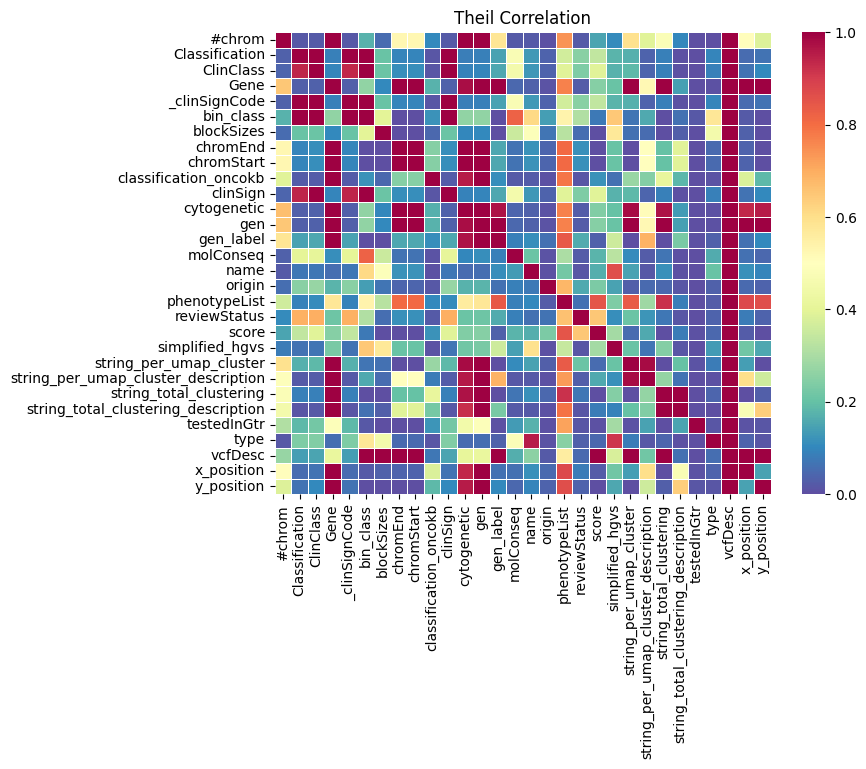

In [5]:
sorted_index = sorted(corr_matrix.index)
sorted_columns = sorted(corr_matrix.columns)
# Reorder the DataFrame
corr_matrix_sorted = corr_matrix.loc[sorted_index, sorted_columns]

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_sorted, vmin=0, vmax=1, cmap="Spectral_r", linewidth=.5)
plt.title("Theil Correlation")
plt.show();

## `Cramer`

In [6]:
mini_merged_df = merged_df.sample(frac=0.1, random_state=2024)
print(mini_merged_df.shape)
corr_gen = associations(mini_merged_df, nom_nom_assoc='cramer', num_num_assoc='spearman', clustering=True, multiprocessing=True, compute_only=True)
corr_matrix = corr_gen["corr"]
pair_df = select_vars(corr_matrix)
variable_to_drop = choose_variable_to_drop(pair_df)
print(f"Variable to drop: {variable_to_drop}")

(32812, 30)
Variable to drop: Gene


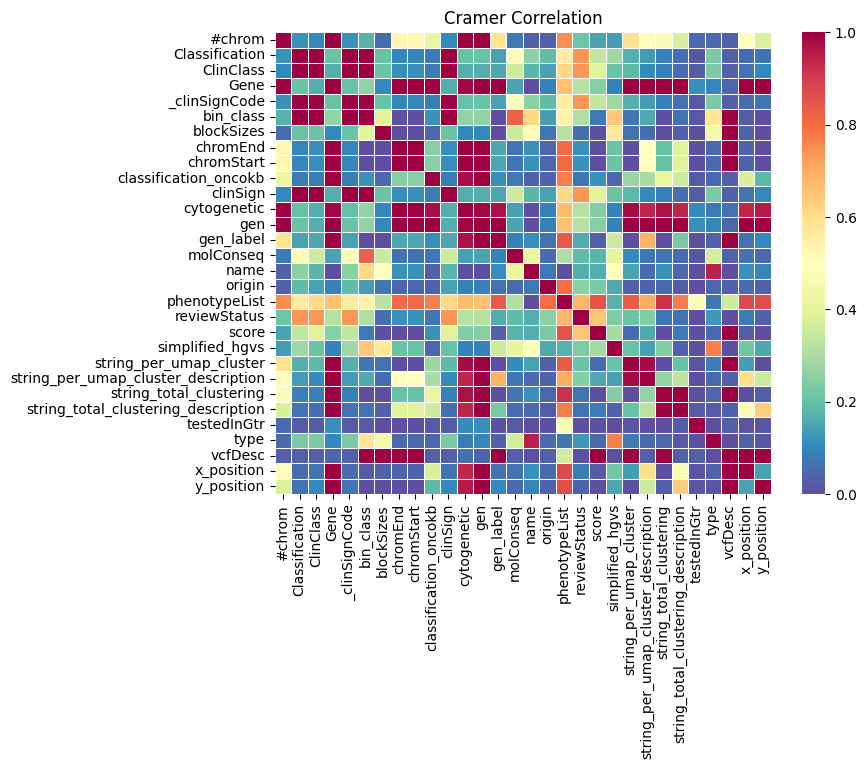

In [7]:
sorted_index = sorted(corr_matrix.index)
sorted_columns = sorted(corr_matrix.columns)
# Reorder the DataFrame
corr_matrix_sorted = corr_matrix.loc[sorted_index, sorted_columns]

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_sorted, vmin=0, vmax=1, cmap="Spectral_r", linewidth=.5)
plt.title("Cramer Correlation")
plt.show();

## Mutual Information

In [8]:
merged_df["gen_label"] = merged_df["gen_label"].fillna(99)
print(merged_df.shape)
mi_matrix = mutual_information(merged_df)

(328116, 30)


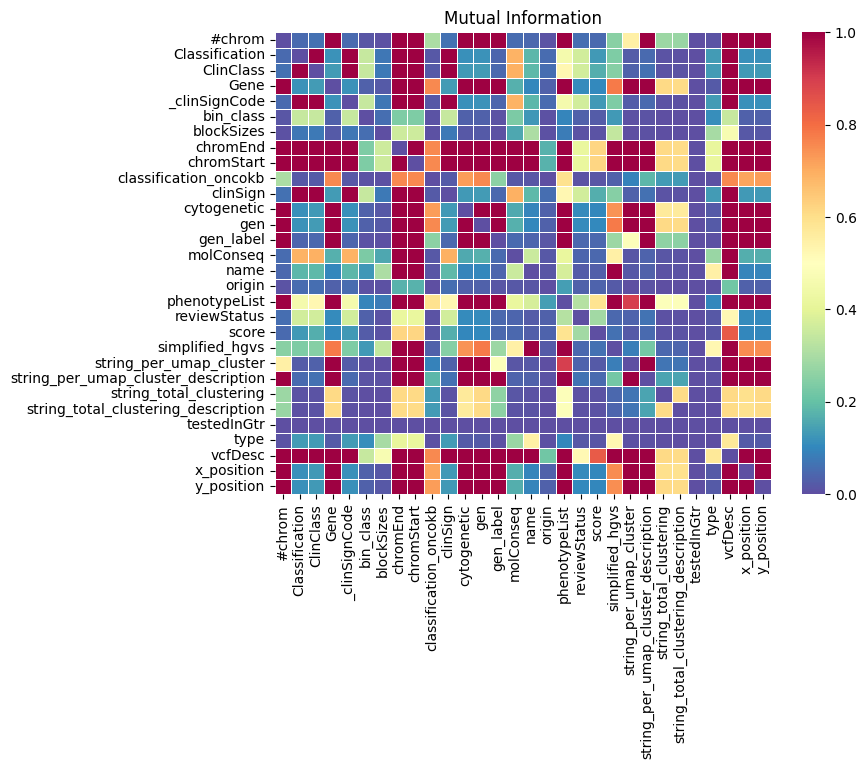

In [9]:
for i in mi_matrix.columns:
    mi_matrix[i] = mi_matrix[i].astype(float)

sorted_index = sorted(mi_matrix.index)
sorted_columns = sorted(mi_matrix.columns)
# Reorder the DataFrame
mi_matrix_sorted = mi_matrix.loc[sorted_index, sorted_columns]

plt.figure(figsize=(8,6))
sns.heatmap(mi_matrix_sorted, vmin=0, vmax=1, cmap="Spectral_r", linewidth=.5)
plt.title("Mutual Information")
plt.show();

In [10]:
pair_df = select_vars(mi_matrix)
variable_to_drop = choose_variable_to_drop(pair_df)
print(f"Variable to drop: {variable_to_drop}")

Variable to drop: chromStart


<hr style="height:3px;border-width:0;color:gray;background-color:gray">

# XGBoost Feature Importance

- Eliminando información de clasificación clínica: `bin_class`, `Classification`, `_clinSignCode`, `ClinClass`
- Eliminando columnas indicadas en fase anterior: `chromStart`, `chromEnd`, `vcfDesc`, `testedInGtr`
- Eliminando columnas equivalentes como: `string_per_umap_cluster`, `string_per_umap_cluster`

In [11]:
merged_df["gen_label"] = merged_df["gen_label"].astype(int).fillna(99).astype("category") 
merged_df["x_position"] = merged_df["x_position"].astype(float)
merged_df["y_position"] = merged_df["y_position"].astype(float)

In [12]:
# Data preparation
X = merged_df.drop(["bin_class", "Classification", "_clinSignCode", 
                    'clinSign', "ClinClass", "chromStart", "chromEnd", "gen", 
                    "vcfDesc", "testedInGtr", "string_per_umap_cluster", "string_total_clustering"], axis=1)
y = merged_df["bin_class"]

# Treat all columns as categories
for i in X.columns:
    if i in ["x_position", "y_position"]:
        X[i] = preprocessing.scale(X[i])
    else:
        X[i] = X[i].astype("category")

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Initialize the RepeatedStratifiedKFold with 5 splits and 3 repetitions
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Define parameters for XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    "enable_categorical": True
}

# Lists to store metrics across folds and repetitions
f1_scores = []
precision_scores = []
accuracy_scores = []
recall_scores = []
specificity_scores = []
feature_importances = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(rskf.split(X_train, y_train)):
    # Split data into training and validation for the current fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize and train the XGBoost model
    model = XGBClassifier(**xgb_params)
    model.fit(X_fold_train, y_fold_train, 
              eval_set=[(X_fold_val, y_fold_val)],
              verbose=False)
    
    # Predict on the validation set
    val_pred = model.predict(X_fold_val)
    
    # Compute metrics
    f1_scores.append(f1_score(y_fold_val, val_pred))
    precision_scores.append(precision_score(y_fold_val, val_pred))
    accuracy_scores.append(accuracy_score(y_fold_val, val_pred))
    recall_scores.append(recall_score(y_fold_val, val_pred))
    
    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_fold_val, val_pred).ravel()
    specificity = tn / (tn + fp)
    specificity_scores.append(specificity)
    
    # Store feature importances for averaging later
    feature_importances.append(model.feature_importances_)

# Compute the mean and standard deviation for each metric
metrics = {
    'F1 Score': (np.mean(f1_scores), np.std(f1_scores)),
    'Precision': (np.mean(precision_scores), np.std(precision_scores)),
    'Accuracy': (np.mean(accuracy_scores), np.std(accuracy_scores)),
    'Recall': (np.mean(recall_scores), np.std(recall_scores)),
    'Specificity': (np.mean(specificity_scores), np.std(specificity_scores))
}

# Display the results
metrics_df = pd.DataFrame(metrics, index=['Mean', 'Standard Deviation'])
print(metrics_df)
print()

# Evaluate on the test set using the trained model from the last fold
test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
test_f1_score = f1_score(y_test, test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1_score:.4f}")
print()
print(classification_report(y_test, test_pred))

# Average the feature importances across all folds and repetitions
mean_feature_importances = pd.DataFrame(feature_importances).mean(axis=0)
mean_feature_importances.index = X.columns

# Display the average feature importances
print()
print("Average Feature Importances:")
print(mean_feature_importances.sort_values(ascending=False))

                    F1 Score  Precision  Accuracy    Recall  Specificity
Mean                0.875327   0.864236  0.972486  0.886722     0.982970
Standard Deviation  0.003656   0.004360  0.000810  0.004561     0.000608

Test Set Accuracy: 0.9728
Test Set F1 Score: 0.8765

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     87713
           1       0.87      0.89      0.88     10722

    accuracy                           0.97     98435
   macro avg       0.93      0.93      0.93     98435
weighted avg       0.97      0.97      0.97     98435


Average Feature Importances:
molConseq                              0.793166
phenotypeList                          0.043244
Gene                                   0.036485
reviewStatus                           0.032244
score                                  0.027332
origin                                 0.014766
cytogenetic                            0.011024
simplified_hgvs                   

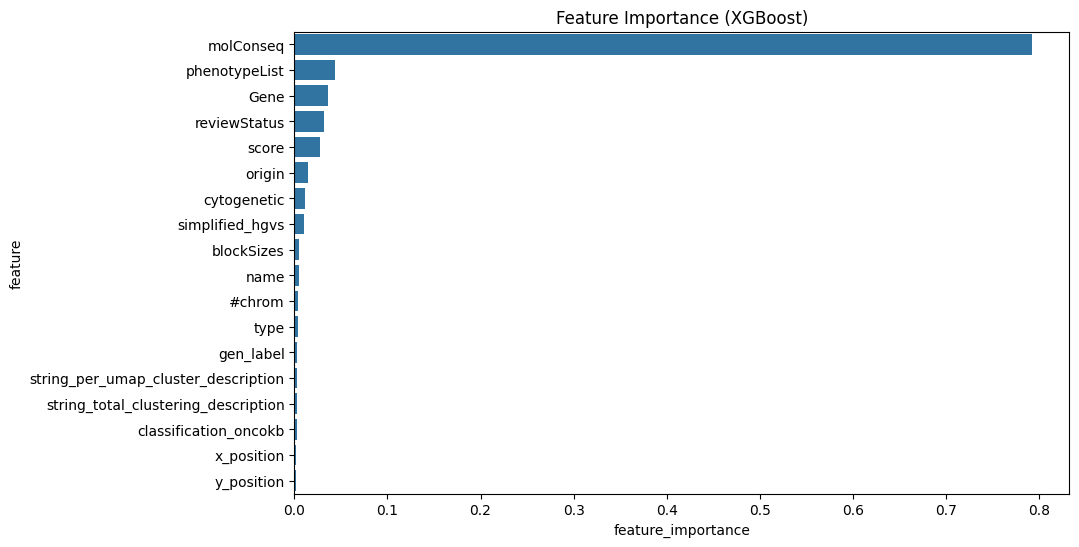

In [13]:
xgb_importances = pd.DataFrame(mean_feature_importances)
xgb_importances = xgb_importances.reset_index()
xgb_importances.columns = ["feature", "feature_importance"]
xgb_importances= xgb_importances.sort_values(by="feature_importance", ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (XGBoost)")
sns.barplot(data=xgb_importances, y="feature", x="feature_importance")
plt.show();

<hr style="height:3px;border-width:0;color:gray;background-color:gray">

# Random Forest Feature Importance

- Eliminando información de clasificación clínica: `bin_class`, `Classification`, `_clinSignCode`, `ClinClass`
- Eliminando columnas indicadas en fase anterior: `chromStart`, `chromEnd`, `vcfDesc`, `testedInGtr`
- Eliminando columnas equivalentes como: `string_per_umap_cluster`, `string_per_umap_cluster`

In [14]:
# Data preparation
X = merged_df.drop(["bin_class", "Classification", "_clinSignCode", 
                    'clinSign', "ClinClass", "chromStart", "chromEnd", "gen", 
                    "vcfDesc", "testedInGtr", "string_per_umap_cluster", "string_total_clustering"], axis=1)
y = merged_df["bin_class"]

categorical_variables = X.select_dtypes("category").columns.to_list()

# Create a copy of the DataFrame to avoid modifying the original one
df_encoded = X.copy()

# Iterate over each categorical variable and apply the BinaryEncoder
for col in categorical_variables:
    encoder = BinaryEncoder(cols=[col])
    encoded_cols = encoder.fit_transform(df_encoded[col])
    
    # Drop the original categorical column and add the encoded columns
    df_encoded = df_encoded.drop(col, axis=1)
    df_encoded = pd.concat([df_encoded, encoded_cols], axis=1)

df_encoded["x_position"] = preprocessing.scale(df_encoded["x_position"])
df_encoded["y_position"] = preprocessing.scale(df_encoded["y_position"])

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.3, stratify=y, random_state=42)

# Initialize the RepeatedStratifiedKFold with 5 splits and 3 repetitions
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Lists to store metrics across folds and repetitions
f1_scores = []
precision_scores = []
accuracy_scores = []
recall_scores = []
specificity_scores = []
feature_importances = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(rskf.split(X_train, y_train)):
    # Split data into training and validation for the current fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize and train the XGBoost model
    model = RandomForestClassifier()
    model.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set
    val_pred = model.predict(X_fold_val)
    
    # Compute metrics
    f1_scores.append(f1_score(y_fold_val, val_pred))
    precision_scores.append(precision_score(y_fold_val, val_pred))
    accuracy_scores.append(accuracy_score(y_fold_val, val_pred))
    recall_scores.append(recall_score(y_fold_val, val_pred))
    
    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_fold_val, val_pred).ravel()
    specificity = tn / (tn + fp)
    specificity_scores.append(specificity)
    
    # Store feature importances for averaging later
    feature_importances.append(model.feature_importances_)

# Compute the mean and standard deviation for each metric
metrics = {
    'F1 Score': (np.mean(f1_scores), np.std(f1_scores)),
    'Precision': (np.mean(precision_scores), np.std(precision_scores)),
    'Accuracy': (np.mean(accuracy_scores), np.std(accuracy_scores)),
    'Recall': (np.mean(recall_scores), np.std(recall_scores)),
    'Specificity': (np.mean(specificity_scores), np.std(specificity_scores))
}

# Display the results
metrics_df = pd.DataFrame(metrics, index=['Mean', 'Standard Deviation'])
print(metrics_df)
print()

# Evaluate on the test set using the trained model from the last fold
test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
test_f1_score = f1_score(y_test, test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1_score:.4f}")
print()
print(classification_report(y_test, test_pred))

# Average the feature importances across all folds and repetitions
mean_feature_importances = pd.DataFrame(feature_importances).mean(axis=0)
mean_feature_importances.index = df_encoded.columns

# Display the average feature importances
print()
print("Average Feature Importances:")
print(mean_feature_importances.sort_values(ascending=False))

# Get feature importances
importances = mean_feature_importances.copy()
feature_names = df_encoded.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

                    F1 Score  Precision  Accuracy    Recall  Specificity
Mean                0.859410   0.853801  0.969169  0.865110     0.981889
Standard Deviation  0.004165   0.005289  0.000935  0.004535     0.000731

Test Set Accuracy: 0.9696
Test Set F1 Score: 0.8612

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     87713
           1       0.86      0.86      0.86     10722

    accuracy                           0.97     98435
   macro avg       0.92      0.92      0.92     98435
weighted avg       0.97      0.97      0.97     98435


Average Feature Importances:
molConseq_3                              0.275074
type_2                                   0.088740
molConseq_1                              0.067852
blockSizes_5                             0.030094
molConseq_2                              0.026676
                                           ...   
string_per_umap_cluster_description_0    0.000514
string_total_cluster

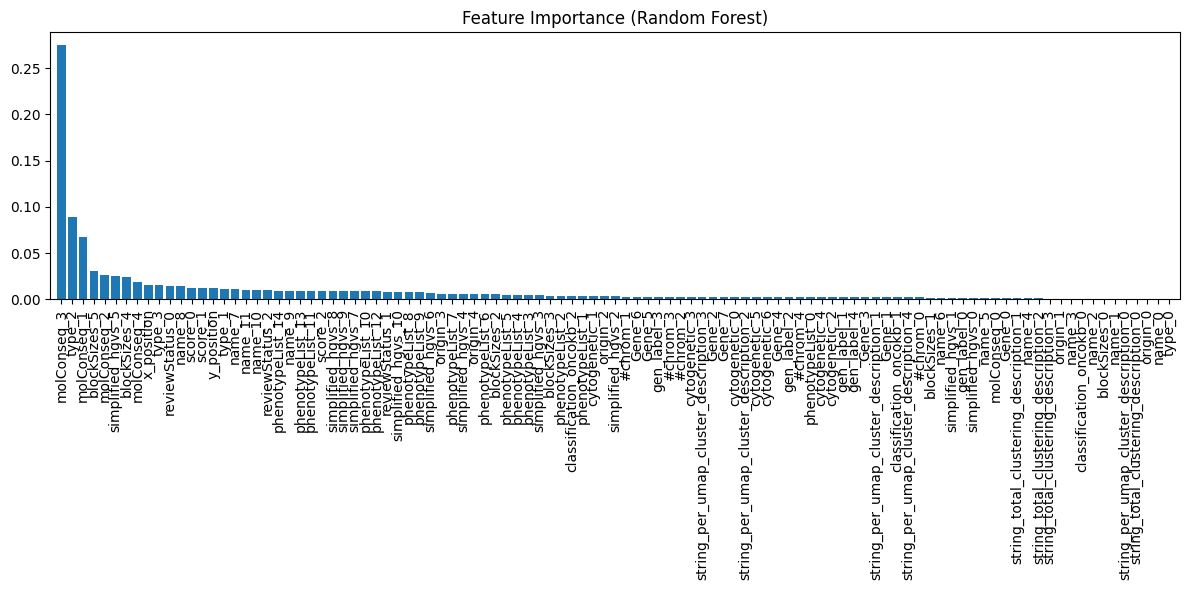

In [15]:
# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(df_encoded.shape[1]), mean_feature_importances[indices], color="tab:blue")
plt.xticks(range(df_encoded.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, df_encoded.shape[1]])
plt.tight_layout()
plt.show()

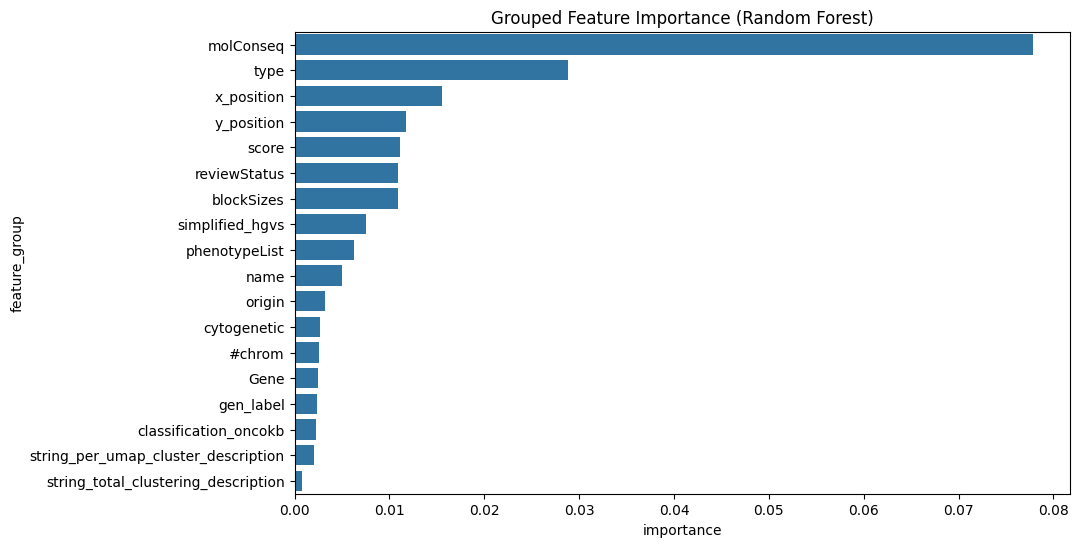

In [16]:
# Create a DataFrame from the feature names and importances
df_rf = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Extract the initial part of the feature name (e.g., #chrom from #chrom_0)
df_rf['feature_group'] = df_rf['feature'].str.replace(r'_\d+$', '', regex=True)

# Group by the feature group and calculate the mean importance
grouped_importances = df_rf.groupby('feature_group')['importance'].mean().reset_index()
grouped_importances = grouped_importances.sort_values(by="importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Grouped Feature Importance (Random Forest)")
sns.barplot(data=grouped_importances, y="feature_group", x="importance")
plt.show();